# Main notebook with methods and results

## Imports

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from src.util.utils import read_data

## Visualization of data

In [3]:
# Read the data
Xtr, Ytr, Xte = read_data()

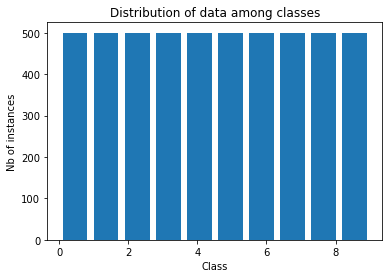

In [4]:
plt.hist(Ytr, bins=10, rwidth=0.8)
plt.title("Distribution of data among classes")
plt.xlabel("Class")
plt.ylabel("Nb of instances")
plt.show()

We can see that the data is well-distributed among classes, which dismisses the need of balancing.

Now, we visualize one image per class:

[0.49553318 0.50350592 0.4974744  ... 0.4661161  0.53247126 0.57380202]
-0.2115899
0.2094491
[0.5149362  0.50421826 0.50973227 ... 0.48900347 0.47403436 0.4742136 ]
-0.1758994
0.1616076
[0.4928603  0.48648874 0.49186025 ... 0.49165527 0.49756183 0.4906236 ]
-0.1617978
0.1502315
[0.48322143 0.50666185 0.49277429 ... 0.50327243 0.48625507 0.50096848]
-0.1668106
0.2186121
[0.42690934 0.45320046 0.44376533 ... 0.47072762 0.5013679  0.49852466]
-0.1576062
0.1831707


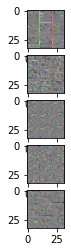

In [5]:
n_classes = 10
img_shp = (32, 32, 3)
fig, axs = plt.subplots(5)
for i, ax in enumerate(axs):
    idx = np.where(Ytr == i)[0][0]
    print(Xtr[idx] + 0.5)
    print(np.min(Xtr[idx]))
    print(np.max(Xtr[idx]))
    ax.imshow(Xtr[idx].reshape(img_shp)*2 + 0.5)


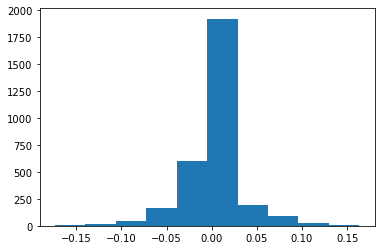

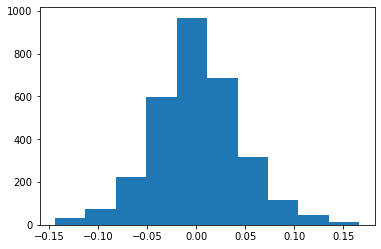

(array([   7.,   21.,  181.,  964., 1286.,  460.,  114.,   27.,   10.,
           2.]),
 array([-0.1668106 , -0.12826833, -0.08972606, -0.05118379, -0.01264152,
         0.02590075,  0.06444302,  0.10298529,  0.14152756,  0.18006983,
         0.2186121 ]),
 <BarContainer object of 10 artists>)

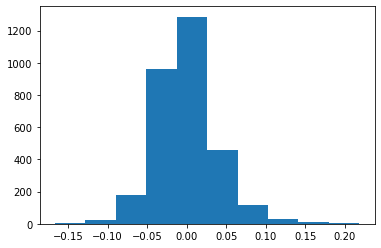

In [6]:
# Plot distribution of 

plt.hist(Xtr[0].flatten())
plt.show()
plt.hist(Xtr[1].flatten())
plt.show()
plt.hist(Xtr[2].flatten())


## Denoising

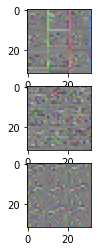

In [7]:
n_classes = 10
img_shp = (32, 32, 3)
nb_subplots = 3
fig, axs = plt.subplots(nb_subplots)
for i, ax in enumerate(axs):
    idx = np.where(Ytr == i)[0][0]
    ax.imshow(Xtr[idx].reshape(img_shp)*2 + 0.5)

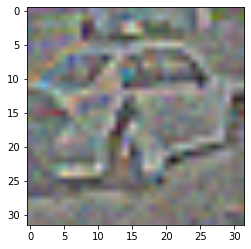

In [8]:
import cv2
from PIL import Image
from src.methods.min_max_scaler import MinMaxScaler

scaler = MinMaxScaler()
Xtr_scaled = scaler.fit_and_transform(Xtr)
img = Xtr_scaled[3].reshape(img_shp, order='F')
img = img.transpose(1, 0, 2)
# print(img[:10, :10, :])
plt.imshow(img, cmap="viridis", interpolation='bilinear')
# , alpha = 0.7, 
#    interpolation ='bilinear'
plt.show()
# img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# print(img)
# img_pil = Image.fromarray()
# img = Image.fromarray(Xtr[0].reshape(img_shp)*2 + 0.5)


In [9]:

# img_ = Image.fromarray((img * 255.).astype(np.uint8))
# img_.show()
median = cv2.medianBlur((img * 255.).astype(np.uint8), 3)

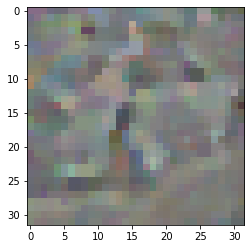

In [10]:
plt.imshow(median)
plt.show()

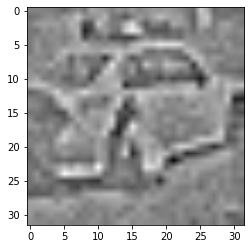

In [11]:
R = 0.2989
G = 0.5870
B = 0.1140

a = np.array([R, G, B]).reshape(3,1)
img_bw = np.dot(img, a)
plt.imshow(img_bw, cmap="gray", interpolation='bilinear')
plt.show()

In [12]:
from scipy import signal
from scipy import misc
ascent = img_bw.reshape(img_bw.shape[0], img_bw.shape[1])
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy
grad = signal.convolve2d(ascent, scharr, boundary='symm', mode='same')

/var/folders/_d/zhpqkyn95dz_fbw06x_k2v7h0000gn/T/ipykernel_4898/2143889961.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


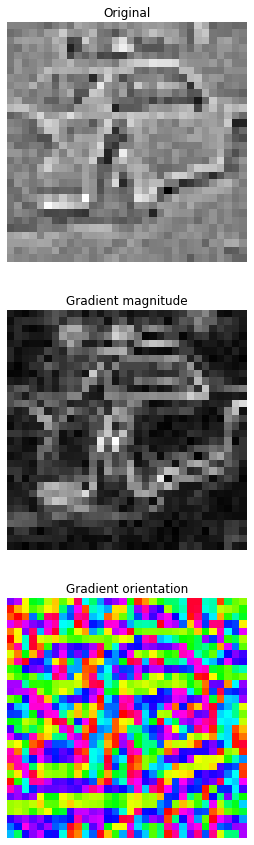

In [13]:
fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(ascent, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='hsv') # hsv is cyclic, like angles
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()
fig.show()

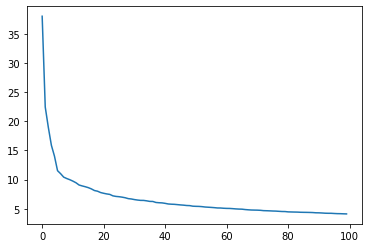

In [14]:
from src.util.kernels import RBF, Linear
from src.methods.kernel_pca import Kernel_PCA

Xtr_scaled_ = Xtr_scaled.reshape(Xtr_scaled.shape[0], *img_shp)
Xtr_scaled_bw = np.dot(Xtr_scaled_, a)
Xtr_flat = Xtr_scaled_bw.reshape(Xtr_scaled_bw.shape[0], -1)
kernel_fn = RBF(sigma=40).kernel
# Normalize first
mean = np.mean(Xtr_flat, axis=0)
std = np.std(Xtr_flat, axis=0)
Xtr_n = (Xtr_flat - mean) / std

pca = Kernel_PCA(n_components=100, kernel_fn=kernel_fn)
Xtr_tr = pca.fit_and_transform(Xtr_n)
plt.plot(pca.eigenvals)
plt.show()


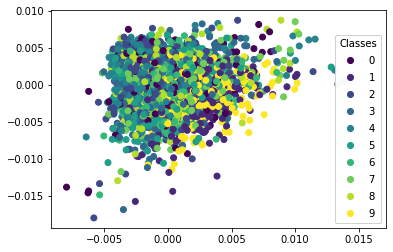

In [15]:
fig, ax = plt.subplots()
scatter = ax.scatter(Xtr_tr[:, 0], Xtr_tr[:, 1], c=Ytr)
# plt.scatter(Xtr_tr[:, 0], Xtr_tr[:, 1], label=Ytr, c=Ytr)
# plt.legend(title="Classes", loc="upper right")
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
ax.add_artist(legend)
plt.show()

## Preprocessing

In [116]:
from sklearn.decomposition import KernelPCA

# PCA to start?
# plot pca
from src.methods.kernel_pca import Kernel_PCA
from src.util.kernels import RBF, Linear

mean = np.mean(Xtr, axis=0)
std = np.std(Xtr, axis=0)
Xtr_n = (Xtr - mean) / std

# Apply the same to validation
Xval_n = (Xte - mean) / std

# kernel_fn=RBF(sigma=1).kernel
# kernel=RBF(sigma=1).kernel
pca = Kernel_PCA(n_components=1024, kernel_fn=RBF(sigma=1).kernel)
# pca = KernelPCA(n_components=1024, kernel='linear')

Xtr_pca = pca.fit_and_transform(Xtr_n)
Xval_pca = pca.transform(Xval_n)

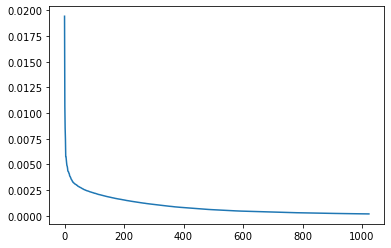

1.0


In [113]:
plt.plot(pca.eigenvalues_ / sum(pca.eigenvalues_))
plt.show()

vars = pca.eigenvalues_

print(np.sum(vars[:1024]) / np.sum(vars))

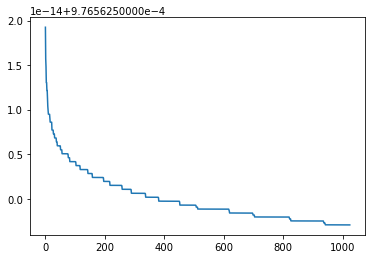

In [118]:
plt.plot(pca.eigen_vals / sum(pca.eigen_vals))
plt.show()

# vars = pca.eigenvalues_

# print(np.sum(vars[:1024]) / np.sum(vars))

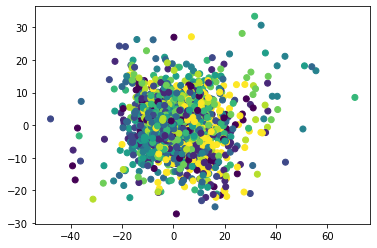

In [114]:
x = Xtr_pca[:, 0]
y = Xtr_pca[:, 1]
plt.scatter(x, y, c=Ytr)

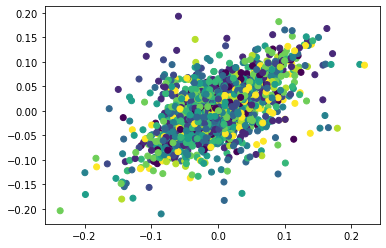

In [111]:
x = Xtr[:, 1]
y = Xtr[:, 2]
plt.scatter(x, y, c=Ytr)

## Classifiers

### Kernel SVM

In [ ]:
# Kernel SVM